In [1]:
!nvidia-smi

Sun Apr  4 06:44:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# install the required bert pretrained model
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 17.2MB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
     |████████████████████████████████| 133kB 44.9MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 7.4MB 56.4MB/s 
ERROR: botocore 1.20.44 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [3]:
# import the required libraries.

import re
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
df = pd.read_csv('/content/Usecase3_Dataset.csv',encoding='utf-8')

In [6]:
df.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...


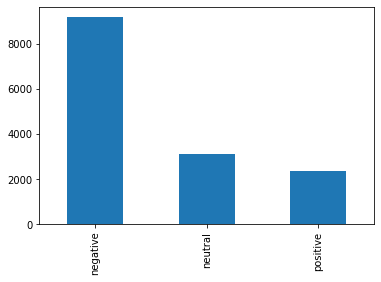

In [7]:
df['airline_sentiment'].value_counts().plot(kind='bar')

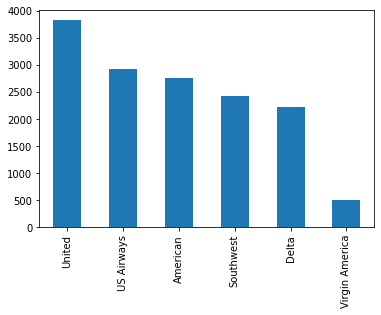

In [8]:
df['airline'].value_counts().plot(kind='bar')

In [9]:
df.rename(columns={'airline_sentiment':'label'},inplace=True)
df = df[['label','text']]
df.head()

,label,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [10]:
df.loc[:,'sentiment'] = df.label.map({'negative':0,'neutral':2,'positive':1})
df = df.drop(['label'], axis=1)
df.head()

,text,sentiment
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [11]:
def preprocess_tweet(tweet):
	#Preprocess the text in a single tweet
	#arguments: tweet = a single tweet in form of string 
	#convert the tweet to lower case
	tweet.lower()
	#convert all urls to sting "URL"
	tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
	#convert all @username to "at_user"
  #tweet = re.sub('@[^\s]+','AT_USER', tweet)
	#correct all multiple white spaces to a single white space
	tweet = re.sub('[\s]+', ' ', tweet)
	#convert "#topic" to just "topic"
	tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
	return tweet

In [12]:
df['text'] = df['text'].apply(preprocess_tweet)
df.head()

,text,sentiment
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [13]:
sentences = df.text.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 16644353.36B/s]


Tokenize the first sentence:
['[CLS]', '@', 'virgin', '##ame', '##rica', 'what', '@', 'dh', '##ep', '##burn', 'said', '.', '[SEP]']


In [16]:
#loading the labels value
labels = df.sentiment.values
#finding maximum length of a tweet
print(df.text.map(lambda x: len(x)).max())

186


In [17]:
# Set the maximum sequence length.
#The longest sequence in our training set its 186
# We will set it to 256
MAX_LEN = 256

In [18]:
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [19]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [20]:
#Pad the sequences
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [21]:
#Printing to see how the second tweet after preprocessing looks.
input_ids[1]

array([  101,  1030,  6261, 14074, 14735,  4606,  2017,  1005,  2310,
        2794, 12698,  2000,  1996,  3325,  1012,  1012,  1012, 26997,
        2100,  1012,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [22]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [23]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [24]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [25]:
# Select a batch size for training. For fine-tuning BERT on a specific task
# A batch size of 16 or 32 is preferred 
# If Cuda goes out of memory try lowering the batch_size.
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [26]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
# Make the num_label = 3 positive,negative,neutral
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.cuda()

100%|██████████| 407873900/407873900 [00:06<00:00, 60385417.22B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [27]:
# Set different weight decays for different layers of the model.

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [28]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=3e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [29]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
